In [4]:
from model import ConvModel
import dgl, torch
import torch.nn as nn
from collections import defaultdict
import numpy as np
from settings import BASE_DIR
import evaluation_metrics
import baseline_model_generator
import matplotlib.pyplot as plt
import random

graphs, _ = dgl.load_graphs(f"{BASE_DIR}/graph_files/ecommerce_hetero_graph_subgraph.dgl")
ecommerce_hetero_graph_subgraph = graphs[0]

graphs, _ = dgl.load_graphs(f"{BASE_DIR}/graph_files/train_g.dgl")
train_g = graphs[0]

graphs, _ = dgl.load_graphs(f"{BASE_DIR}/graph_files/test_g.dgl")
test_g = graphs[0]

graphs, _ = dgl.load_graphs(f"{BASE_DIR}/graph_files/valid_g.dgl")
valid_g = graphs[0]

dim_dict = {'customer': ecommerce_hetero_graph_subgraph.nodes['customer'].data['features'].shape[1],
            'product': ecommerce_hetero_graph_subgraph.nodes['product'].data['features'].shape[1],
            'edge_dim': ecommerce_hetero_graph_subgraph.edges['orders'].data['features'].shape[1],
            'hidden_dim' : 128,
            'out_dim': 64
           }

saved_model = torch.load(f"{BASE_DIR}/graph_files/trained_model.pth")

mpnn_model = ConvModel(ecommerce_hetero_graph_subgraph, 3, dim_dict)
mpnn_model.load_state_dict(saved_model['model_state_dict'])
mpnn_model.eval()

from collections import defaultdict

# for test, get ground truth entites (entites that users will request in the future)
def get_test_recs(g):

    customers_test, products_test  = (g.edges(etype='orders'))
    already_rated_arr = np.stack((np.asarray(customers_test), np.asarray(products_test)), axis=1)
    test_rated_dict = defaultdict(set)
    
    for key, val in already_rated_arr:
        test_rated_dict[key].add(val)
    
    final_history = defaultdict(list)
    
    final_history = defaultdict(list)
    for key, value in test_rated_dict.items():
        final_history[key] = list(set(value))
        
    return final_history

def create_already_rated(g):
    
    customers_train, product_train  = (g.edges(etype='orders'))
    already_rated_arr = np.stack((np.asarray(customers_train), np.asarray(product_train)), axis=1)
    already_rated_dict = defaultdict(list)
    
    for key, val in already_rated_arr:
        already_rated_dict[key].append(val)
        
    return already_rated_dict

already_rated_dict = create_already_rated(train_g)
recommendations_from_valid_graph = get_test_recs(valid_g)

neg_sampler = dgl.dataloading.negative_sampler.Uniform(2)
node_sampler = dgl.dataloading.NeighborSampler(fanouts=[-1, -1])

edge_sampler = dgl.dataloading.EdgePredictionSampler(
    node_sampler,
    negative_sampler=neg_sampler,
    exclude='self')

valid_eids_dict = {}

eids = np.arange(valid_g.number_of_edges(etype='orders'))

for e in valid_g.etypes:
    valid_eids_dict[e] = eids

print(valid_g)

valid_dataloader = dgl.dataloading.DataLoader(ecommerce_hetero_graph_subgraph, valid_eids_dict, edge_sampler,  shuffle=True, drop_last= False, batch_size=1024, num_workers=0)

train_embeddings = {ntype: torch.zeros(valid_g.num_nodes(ntype), 64)
         for ntype in valid_g.ntypes}

for arg0 , pos_g, neg_g, blocks in valid_dataloader:

    output_nodes = pos_g.ndata[dgl.NID]

    input_features = blocks[0].srcdata['features']
    edge_features = blocks[0].edata['features']

    edge_features_HM = {}
    for key, value in edge_features.items():
        edge_features_HM[key[1]] = (value, )
    
    input_features['customer'] = mpnn_model.user_embed(input_features['customer'])
    input_features['product'] = mpnn_model.item_embed(input_features['product'])

    print("Input features shape", input_features['customer'].shape, input_features['product'].shape)
    
    h = mpnn_model.get_repr(blocks, input_features, edge_features_HM)

    print("Output features shape", h['customer'].shape, h['product'].shape)
    for ntype in h.keys():
        train_embeddings[ntype][output_nodes[ntype]] = h[ntype]

print(train_embeddings['customer'][0], train_embeddings['customer'].shape, train_embeddings['product'].shape)

print('zeros count', train_embeddings['product'][3].shape[0] - torch.count_nonzero(train_embeddings['product'][3]))

def get_model_recs():

    user_ids = valid_g.num_nodes('customer')
        
    recs = {}

    for user in range(user_ids):

        already_rated = already_rated_dict[user]

        user_emb = train_embeddings['customer'][user]
        # user_emb_rpt = torch.cat(valid_g.num_nodes('product')*[user_emb]).reshape(-1, dim_dict['out_dim'])
        user_emb_rpt = user_emb.repeat(valid_g.num_nodes('product'), 1)

        # print("User embedding shape",y['product'].shape, user_emb_rpt.shape)
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        ratings = cos(user_emb_rpt, train_embeddings['product'])
        
        ratings_formatted = ratings.detach().numpy().reshape(valid_g.num_nodes('product'),)
        order = np.argsort(-ratings_formatted)
        
        #order = [item for item in order if item not in already_rated]
        
        recs[user] = order
    
    return recs

# print(recs)

model_recommendations = get_model_recs()
print(len(model_recommendations[0]))


def compare_rec(ground_truth_recs, model_recs, threshold = 10):
  
    total = 0
    correct = 0 

    for key, value in model_recs.items():

        model_recs_list = model_recs[key]
        ground_truth_recs_list = ground_truth_recs[key][:10]

        recommended_movies_correct = list(set(model_recs_list) & set(ground_truth_recs_list))

        if len(set(ground_truth_recs_list)) > 0:

            # print("User ID", key, "Correctly predicted movies", recommended_movies_correct)
            # print("Total test values", len(recommended_movies_correct), "out of", len(set(test_recs_list)))
        
            correct += len(recommended_movies_correct)
            total += len(set(ground_truth_recs_list))
        # print("Ratings", [ ratings_HM[movie_id] for movie_id in recommended_movies_correct ])

    return correct, total


print(compare_rec(recommendations_from_valid_graph, model_recommendations))

Graph(num_nodes={'customer': 788, 'product': 56},
      num_edges={('customer', 'orders', 'product'): 100, ('product', 'rev-orders', 'customer'): 100},
      metagraph=[('customer', 'product', 'orders'), ('product', 'customer', 'rev-orders')])
Input features shape torch.Size([788, 128]) torch.Size([56, 128])
Output features shape torch.Size([250, 64]) torch.Size([56, 64])
tensor([0.0000, 0.0000, 0.3865, 0.0000, 0.3234, 0.0460, 0.0000, 0.5321, 0.3100,
        0.0000, 0.3277, 0.0402, 0.0000, 0.0000, 0.2788, 0.0000, 0.3529, 0.0000,
        0.0000, 0.9256, 0.0000, 0.1459, 0.0000, 0.2337, 0.0000, 0.0000, 0.2518,
        0.0000, 0.0000, 0.7443, 0.0000, 0.0000, 0.0000, 0.0000, 0.2762, 0.3914,
        0.0666, 0.1000, 0.1577, 0.0000, 0.0000, 0.0747, 0.0000, 0.0772, 0.0000,
        0.3566, 0.0000, 0.1180, 0.1514, 0.7974, 0.0000, 0.0583, 0.4804, 0.0000,
        0.7146, 0.0000, 0.6160, 0.0993, 0.3943, 0.3657, 0.0000, 0.0000, 0.0000,
        0.5713], grad_fn=<SelectBackward0>) torch.Size([788, 64])

In [5]:
HM = defaultdict(list)
for key, value in recommendations_from_valid_graph.items():
    HM[key] = list(set(value))

In [6]:
baseline_model = baseline_model_generator.generate_popularity_model(ecommerce_hetero_graph_subgraph, 'orders', 'customer')
random_model = baseline_model_generator.generate_random_model(ecommerce_hetero_graph_subgraph, 'customer', 'product')

In [7]:
print("MMR Baseline: ",evaluation_metrics.mmr(HM, baseline_model, 1))
print("MMR Random: ",evaluation_metrics.mmr(HM, random_model, 1))
print("MMR GNN Model: ",evaluation_metrics.mmr(HM, model_recommendations, 1))

MMR Baseline:  0.6056546717395268
MMR Random:  0.09387894859982425
MMR GNN Model:  0.033939423291827156


In [8]:
# Compute Hit Rates for every Threshold

thresholds = np.arange(1,len(set(model_recommendations[0]))+1)

hit_rates_acc_baseline = []
hit_rates_acc_random = []
hit_rates_acc_model = []

hit_rates_recall_baseline = []
hit_rates_recall_random = []
hit_rates_recall_model = []

for t in thresholds:
    hit_rates_acc_baseline.append(evaluation_metrics.hit_rate_accuracy(HM, baseline_model, t))
    hit_rates_acc_random.append(evaluation_metrics.hit_rate_accuracy(HM, random_model, t))
    hit_rates_acc_model.append(evaluation_metrics.hit_rate_accuracy(HM, model_recommendations, t))
    hit_rates_recall_baseline.append(evaluation_metrics.hit_rate_recall(HM, baseline_model, t))
    hit_rates_recall_random.append(evaluation_metrics.hit_rate_recall(HM, random_model, t))
    hit_rates_recall_model.append(evaluation_metrics.hit_rate_recall(HM, model_recommendations, t))

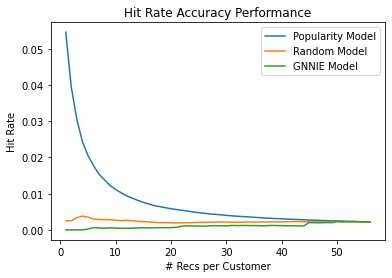

In [9]:
plt.plot(thresholds,hit_rates_acc_baseline, label = "Popularity Model")
plt.plot(thresholds,hit_rates_acc_random, label = "Random Model")
plt.plot(thresholds,hit_rates_acc_model, label = "GNNIE Model")
plt.legend()
plt.xlabel("# Recs per Customer")
plt.ylabel("Hit Rate")
plt.title("Hit Rate Accuracy Performance")
plt.show()

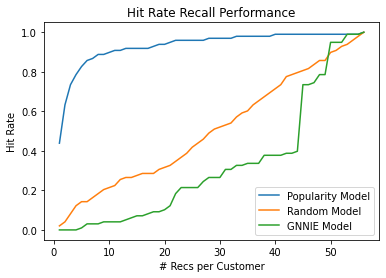

In [10]:
plt.plot(thresholds,hit_rates_recall_baseline, label = "Popularity Model")
plt.plot(thresholds,hit_rates_recall_random, label = "Random Model")
plt.plot(thresholds,hit_rates_recall_model, label = "GNNIE Model")
plt.legend()
plt.xlabel("# Recs per Customer")
plt.ylabel("Hit Rate")
plt.title("Hit Rate Recall Performance")
plt.show()

In [11]:
model_recommendations  #GNNIE

{0: array([12,  3, 11,  1,  5,  0,  8,  9,  6,  4, 47, 10,  2,  7, 37, 54, 21,
        16, 51, 29, 24, 30, 13, 28, 32, 18, 22, 36, 50, 38, 14, 40, 20, 15,
        43, 48, 49, 55, 31, 46, 52, 39, 23, 26, 17, 19, 45, 35, 53, 42, 44,
        27, 33, 34, 25, 41]),
 1: array([12,  3,  6,  9,  7,  1,  8,  0,  5,  2, 10, 11,  4, 37, 54, 28, 16,
        21, 32, 24, 29, 51, 30, 18, 42, 13, 49, 22, 52, 38, 48, 47, 46, 39,
        35, 40, 19, 20, 44, 43, 45, 55, 17, 50, 27, 34, 33, 23, 14, 53, 26,
        36, 31, 25, 15, 41]),
 2: array([12,  3,  1,  9,  6,  0,  5,  8, 11, 10,  2,  4,  7, 47, 52, 49, 21,
        16, 50, 37, 24, 34, 33, 31, 39, 29, 18, 28, 30, 36, 35, 54, 51, 32,
        14, 38, 55, 13, 43, 42, 22, 19, 53, 17, 15, 23, 20, 25, 48, 46, 40,
        41, 45, 27, 44, 26]),
 3: array([12,  3, 11,  1,  4,  8,  0,  5,  9,  6, 47,  7, 10,  2, 54, 37, 34,
        33, 16, 21, 14, 24, 29, 42, 32, 31, 53, 51, 19, 40, 13, 18, 39, 23,
        46, 28, 38, 52, 17, 15, 49, 55, 50, 26, 35, 36, 20, 25

In [12]:
baseline_model #popularity

{0: array([16, 21, 13, 24, 19, 28, 18,  7,  0, 49,  8, 22,  1,  4,  5,  9, 12,
        14, 15, 23, 25, 26, 44, 52,  6, 11, 38, 51,  2,  3, 10, 17, 20, 27,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47,
        48, 50, 53, 54, 55]),
 1: array([16, 21, 13, 24, 19, 28, 18,  7,  0, 49,  8, 22,  1,  4,  5,  9, 12,
        14, 15, 23, 25, 26, 44, 52,  6, 11, 38, 51,  2,  3, 10, 17, 20, 27,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47,
        48, 50, 53, 54, 55]),
 2: array([16, 21, 13, 24, 19, 28, 18,  7,  0, 49,  8, 22,  1,  4,  5,  9, 12,
        14, 15, 23, 25, 26, 44, 52,  6, 11, 38, 51,  2,  3, 10, 17, 20, 27,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47,
        48, 50, 53, 54, 55]),
 3: array([16, 21, 13, 24, 19, 28, 18,  7,  0, 49,  8, 22,  1,  4,  5,  9, 12,
        14, 15, 23, 25, 26, 44, 52,  6, 11, 38, 51,  2,  3, 10, 17, 20, 27,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43

In [13]:
random_model

{0: array([49, 33, 27, 44, 40, 14,  6, 32, 51, 12, 47, 52, 43, 28, 15, 46, 10,
        54, 41, 23, 45,  5, 35, 36, 21, 30, 25,  2,  0, 16, 26,  3, 38, 18,
        37, 29, 42, 50, 34,  8, 24, 48, 39, 11, 13, 20, 31,  1,  4,  9,  7,
        22, 17, 19, 53, 55]),
 1: array([49, 36,  7, 16, 38, 42, 53, 21,  1, 32,  5, 14, 43,  6, 48, 55, 22,
        45, 20, 47, 12, 37, 10, 18,  8, 52, 26, 23, 35, 54, 30, 28, 29, 40,
        44, 27, 13, 31, 51, 39,  3, 24, 15, 34, 33, 11, 17, 19, 41, 25, 50,
         4, 46,  9,  0,  2]),
 2: array([27, 25, 44, 45, 24, 20,  6, 52,  5, 55,  8, 54, 19, 33, 26, 12,  9,
        11, 34, 32, 48,  7, 23, 30, 36, 14,  2, 22, 43, 17,  4, 21,  0, 53,
         1, 47, 51, 41,  3, 16, 49, 50, 13, 15, 37, 42, 18, 31, 39, 35, 40,
        46, 38, 10, 29, 28]),
 3: array([29, 45, 36,  4, 41, 43, 20, 33, 21, 38, 11, 16, 49, 14, 48, 15, 22,
        25, 52, 19, 46,  8,  7, 13,  6, 42, 35,  5, 31, 34, 28, 24, 32, 39,
         3, 54, 23, 12,  1, 51,  0, 30, 44, 53, 17, 10, 50, 26